In [1]:
import numpy as np
import pandas as pd
import math
from src.hdmm.error import expected_error, strategy_supports_workload
from src.hdmm.matrix import EkteloMatrix

from matplotlib import pyplot as plt
from collections import OrderedDict
from src.hdmm.workload import AllRange

In [2]:
s1zero_array = np.zeros((5,4))
s1random_array = np.random.randint(2, size=(5,4))
s1alice_q = np.hstack((s1random_array, s1zero_array))
s1bob_q = np.hstack((s1zero_array, s1random_array))

In [3]:
# write a function that makes workloads not repeat

In [4]:
query = np.random.randint(2, size=(11,8))[0] 
storage = {}

def cache(query, storage, ans, error):
    """caches query into a dictionary with values of (ans, error)"""
    storage[np.array2string(query)] = (ans, error)
    return storage
    
def is_reusable(query, storage):
    """returns whether or not a query is in a strategy matrix 
    (cache)"""
    return np.array2string(query) in storage

def reuse(query, storage):
    """returns tuple with (query answer, error) stored in 
    a storage dictionary"""
    return storage[np.array2string(query)]
    

cache(query, storage, 0.5, 0.5)
is_reusable(query, storage)
reuse(query, storage)

(0.5, 0.5)

In [5]:
def cache_and_reuse(workload, x, eps=0.01, k=0, analyst_labels=[]):
    """
    Takes in workload, database, eps, k (# total update steps PER ANALYST)
    
    Returns list of error per query.
    """
    budgets = {}
    for analyst in list(set(analyst_labels)): 
        budgets[analyst] = k # each analyst starts with k update stepss
    
    error_list = []2
    updated_list = []
    used_cache_list = []
    
    n = x.sum()
    x_norm = x/sum(x)
    storage = {}
    for i, query in enumerate(workload): 
        analyst = analyst_labels[i]
        if is_reusable(query, storage): # reuse step
            noisy_ans, abs_error = reuse(query, storage)
            
            error_list.append(abs_error)
            ans_list.append(noisy_ans)
            updated_list.append(False)
            used_cache_list.append(True)
        elif budgets[analyst] > 0: # not reusable and analyst has update steps left
            noise = np.random.laplace(0, k/(n * eps), 1)[0]
            noisy_ans = (np.dot(query, x_norm)) + noise
            
            true_ans = np.matmul(query, x_norm)
            abs_error = np.abs(noisy_ans - true_ans)
            error_list.append(abs_error)
            
            budgets[analyst] -= 1
            storage = cache(query, storage, noisy_ans, abs_error)
            updated_list.append(True)
            ans_list.append(noisy_ans)
            used_cache_list.append(False)
        elif budgets[analyst] == 0: # this analyst has run out of update steps
            error_list.append(None)
            ans_list.append(None)
            updated_list.append(False)
            used_cache_list.append(False)
    d = {'queries': workload.tolist(), 
        'abs_error': error_list,
        'ans': ans_list,
        'updated': updated_list,
        'used_cache': used_cache_list,
        'analyst': analyst_labels,
    }
    test_data = pd.DataFrame(data=d)
    test_data = test_data.round(3)
    test_data['isNa'] = np.where(test_data.abs_error.isnull(), True, False)
    return test_data

In [53]:
def add_to_strategy(query, strategy):
    """Append query to the end fo the strategy matrix"""
    return np.concatenate((strategy, query), axis = 0)


def cache_and_reconstruct(workload, x, eps=0.01, k=0, analyst_labels=[]):
    """
    Takes in workload, database, eps (privacy budget), k (number of total update steps PER ANALYST). 
    
    Returns list of error per query.
    """
    budgets = {}
    for analyst in list(set(analyst_labels)): 
        budgets[analyst] = k # each analyst starts with k update steps
    
    numAnalysts = len(budgets)
    error_list = []
    updated_list = []
    used_reconstruct_list = []
    used_reuse_list = []
    
    storage = {} # storage dictionary for reuse, k: query,v: error
    strategy = workload[0:0] # workload matrix for reconstruction, 
    # make strategy = empty workload to create matrix of same dtype to be used in reconstruct step (avoid error)
    
    n = x.sum()
    x_norm = x/sum(x) # normalize database
    
    for i, query in enumerate(workload): 
        query = np.expand_dims(query, axis = 0)
        analyst = analyst_labels[i]
        
        # If query has answered before, then use old query answer
        if is_reusable(query, storage): 
            abs_error = reuse(query, storage)
            
            error_list.append(abs_error)
            used_reconstruct_list.append(False) 
            updated_list.append(False)
            used_reuse_list.append(True)
            strategy = add_to_strategy(query, strategy)
        
        # If query is reconstructable, then reconstruct
        elif strategy_supports_workload(EkteloMatrix(query), EkteloMatrix(strategy)): # how to convert numpy array to ektelo matrix https://github.com/yikai-wu/Multi-Analyst-DP/blob/fadc7ac1d20199e8b31914f44323e51a05ed072d/src/hdmm/matrix.py#L34
            
            squared_error = expected_error(query, strategy, len(strategy) / (k * numAnalysts) * eps) # do i mult by 100
            abs_error = math.sqrt(squared_error) / n #
            
            storage[np.array2string(query)] = abs_error
            error_list.append(abs_error)
            updated_list.append(False)
            used_reconstruct_list.append(True) 
            used_reuse_list.append(False)
            strategy = add_to_strategy(query, strategy)
        
        elif budgets[analyst] != 0: # this analyst still has update steps left
            noise = np.random.laplace(0, (k * numAnalysts) / (n * eps), 1)[0]
            noisy_ans = (np.dot(query, x_norm)) + noise
            true_ans = np.matmul(query, x_norm)
            abs_error = np.abs(noisy_ans - true_ans)[0]
            
            error_list.append(abs_error) # *n
            
            storage[np.array2string(query)] = abs_error
            budgets[analyst] -= 1 
            if i != 0:
                strategy = add_to_strategy(query, strategy)
            updated_list.append(True)
            used_reconstruct_list.append(False)
            used_reuse_list.append(False)
            
        elif budgets[analyst] == 0: # this analyst has run out of update steps
            storage[np.array2string(query)] = 'bot'
            error_list.append(None)
            updated_list.append(False)
            used_reconstruct_list.append(False)
            used_reuse_list.append(False)
        
    d = {'queries': workload.tolist(), 
        'abs_error': error_list,
        'updated': updated_list,
        'used_reconstruct': used_reconstruct_list,
        'used_reuse': used_reuse_list,
        'analyst': analyst_labels,
    }
    test_data = pd.DataFrame(data=d)
    test_data = test_data.round(3)
    test_data['isNa'] = np.where(test_data.abs_error.isnull(), True, False)
    return test_data

In [7]:
# db and workloads
x_exp = np.array([20, 160, 20, 160])

s1zero_array = np.zeros((4,2))
s1random_array = np.random.randint(2, size=(4,2))
s1alice_q = np.hstack((s1random_array, s1zero_array))
s1bob_q = np.hstack((s1zero_array, s1random_array))

print('Database:\n', x_exp,'\n')
print('Alice Workload:\n', s1alice_q,'\n')
print('Bob Workload: \n', s1bob_q)

Database:
 [ 20 160  20 160] 

Alice Workload:
 [[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]] 

Bob Workload: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 1.]]


# 2/11 Experiments
In these experiments, I will be testing whether Cache and Reconstruct satisfy our desiderata

- In 2/25, I am testing whether or not our new algorithm satisfy the desiderata

In [37]:
x_exp = np.array([20, 160, 20, 160])

s1alice_q = [[0, 1, 0, 0],
 [1, 0, 0, 0],
 [1, 1, 0, 0],
 [0, 1, 0, 0]]

s1alice_q = np.array(s1alice_q)

s1bob_q = [[0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, 0, 0, 1]]

s1bob_q = np.array(s1bob_q)


In [43]:
# alice and bob's queries that were used in the 2/11 updates
s1alice_q = [[1, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [1, 0, 0, 0]]

s1alice_q = np.array(s1alice_q)

s1bob_q = [[0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0]]

s1bob_q = np.array(s1bob_q)

In [57]:
rec_bob_df = cache_and_reconstruct(s1bob_q, x_exp, eps=2, k=1, analyst_labels=['Bob'] * 4)
rec_bob_df

,queries,abs_error,updated,used_reconstruct,used_reuse,analyst,isNa
0,"[0, 0, 1, 0]",0.001,True,False,False,Bob,False
1,"[0, 0, 1, 0]",0.001,False,False,True,Bob,False
2,"[0, 0, 0, 1]",NaN,False,False,False,Bob,True
3,"[0, 0, 1, 0]",0.001,False,False,True,Bob,False


In [55]:
# reconstruct exp

rec_joint_df = cache_and_reconstruct(np.vstack((s1alice_q, s1bob_q)), x_exp, eps=2, k=2, 
                      analyst_labels=['Alice'] * 4 + ['Bob'] * 4)
rec_joint_df

,queries,abs_error,updated,used_reconstruct,used_reuse,analyst,isNa
0,"[1, 0, 0, 0]",0.002,True,False,False,Alice,False
1,"[1, 0, 0, 0]",0.002,False,False,True,Alice,False
2,"[0, 1, 0, 0]",0.012,True,False,False,Alice,False
3,"[1, 0, 0, 0]",0.002,False,False,True,Alice,False
4,"[0, 0, 1, 0]",0.002,True,False,False,Bob,False
5,"[0, 0, 1, 0]",0.002,False,False,True,Bob,False
6,"[0, 0, 0, 1]",0.012,True,False,False,Bob,False
7,"[0, 0, 1, 0]",0.002,False,False,True,Bob,False


<AxesSubplot:>

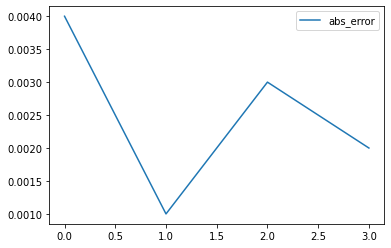

In [12]:
rec_df.plot()